## Brando Magnani, N16654444

## HW2 Problem 3

## (subparts 1,2,3,4,5,6.c)

In [168]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd

# stats
#import statsmodels.api as sm
import scipy.stats as stats

# plots
import matplotlib.pyplot as plt
#import seaborn as sns

# utils
import os, re

from libsvm.svmutil import *

In [2]:
column_names = ["sex", "length", "diameter", "height", "whole weight",
                "shucked weight", "viscera weight", "shell weight", "rings"]

xlab = column_names[0:len(column_names)-1]
ylab = column_names[len(column_names)-1]
data = pd.read_csv("abalone.data", names=column_names)
print("Number of samples: %d" % len(data))
data.head()

Number of samples: 4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Give a numerical label to "sex" feature: M -> 0, F -> 1, I -> 2
# Assign 1 to rings <= 9, 0 else
r1 = np.arange(0,10,1)
r2 = np.arange(10,data["rings"].max(), 1)

data["sex"].replace("M", 0, inplace=True)
data["sex"].replace("F", 1, inplace=True)
data["sex"].replace("I", 2, inplace=True)
data["rings"].replace(r1,  1, inplace=True)
data["rings"].replace(r2,  -1, inplace=True)
data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,-1
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,-1
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1


## Part 2.

In [4]:
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import KFold

In [5]:
ntrain = 3133
data_train = data.iloc[0:ntrain,:]  # testing data
data_test  = data.iloc[ntrain:,:]   # training data

Xtrain = data_train[xlab]
Ytrain = data_train[ylab]

Xtest = data_test[xlab]
Ytest = data_test[ylab]

In [6]:
# Scaling
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

## Part 3

In [7]:
# Support Vector Classification, based on libsvm

dlist = [1,2,3,4,5]   # list of degrees
k = 3
Clist     = np.linspace(3.0**(-k), 3**k, 5)
n_splits = 5   # number of cross validation splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=17)

error_dC = np.zeros((len(dlist),len(Clist)))   # contains average validation errors as fn of d, C

CV_errorList = []  # given d, C, contains list of errors in 5-fold cross validation

In [8]:
# for each degree d, for each constant C, do 5-fold cross validation and compute error
for i,d in enumerate(dlist):
    for j,C in enumerate(Clist):
        for train_index, test_index in kf.split(Xtrain):
            svc_pol  = SVR(kernel='poly', degree=d, C=C)
            svc_pol  = svc_pol.fit( Xtrain[train_index], Ytrain[train_index] )
            
            yhat_pol = np.sign(svc_pol.predict(Xtrain[test_index]))
            svc_pol_resid = yhat_pol - Ytrain[test_index].values
            error = np.sum(np.abs(svc_pol_resid/2.))/float(len(yhat_pol))
    
            CV_errorList.append(error)
        error_dC[i,j] = np.average(CV_errorList)
        CV_errorList = []
        #print(i,j)

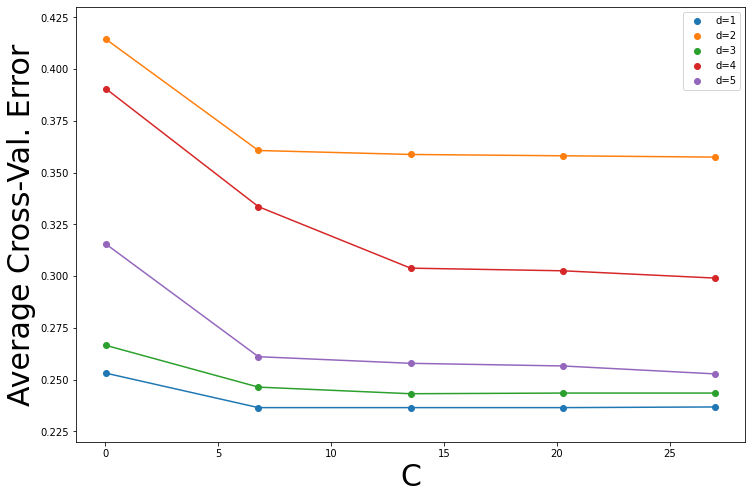

In [59]:
# Plot Average Cross-Val. Error vs C

plt.figure(figsize=(12, 8))
plt.scatter(Clist, error_dC[0, :], label='d=1')
plt.plot(Clist, error_dC[0, :])
plt.scatter(Clist, error_dC[1, :], label='d=2')
plt.plot(Clist, error_dC[1, :])
plt.scatter(Clist, error_dC[2, :], label='d=3')
plt.plot(Clist, error_dC[2, :])
plt.scatter(Clist, error_dC[3, :], label='d=4')
plt.plot(Clist, error_dC[3, :])
plt.scatter(Clist, error_dC[4, :], label='d=5')
plt.plot(Clist, error_dC[4, :])
plt.xlabel("C", size=30)
plt.ylabel("Average Cross-Val. Error", size=30)
plt.legend()
plt.ylim(.22,0.43)
plt.show()

## Part 4.

In [57]:
d_star = 1
C_star = Clist[np.argmin(error_dC[0, :])]

error_d = np.zeros(len(dlist))   # contains average validation errors as fn of d, given C^*

supp_vec_d = np.zeros(len(dlist))   # contains average number of support vectors (alpha_i != 0)

mh_vec_d  = np.zeros(len(dlist))    # average number of vectors on marginal hyperplanes (alpha_i != C_star)

CV_errorList = []  # given d, contains list of errors in 5-fold cross validation

CV_supp_vecList = []  # given d,  contains list of number of support vectors in 5-fold cross validation

CV_mh_vecList = []

In [58]:
# for each degree d, given C^*, do 5-fold cross validation and compute error
for i,d in enumerate(dlist):
    for train_index, test_index in kf.split(Xtrain):
        svc_pol  = SVR(kernel='poly', degree=d, C=C_star)
        svc_pol  = svc_pol.fit( Xtrain[train_index], Ytrain[train_index] )
        dual_coeff  = (svc_pol.dual_coef_)[0,:].tolist()
        n_sv = len(dual_coeff)    # number of support vectors (alpha_i != 0)
        CV_supp_vecList.append(n_sv)     
        n_marg = n_sv - dual_coeff.count(C_star)   # number of vectors on marginal hyperplanes (alpha_i != C_star)
        CV_mh_vecList.append(n_marg)
        yhat_pol = np.sign(svc_pol.predict(Xtrain[test_index]))
        svc_pol_resid = yhat_pol - Ytrain[test_index].values
        error = np.sum(np.abs(svc_pol_resid/2.))/float(len(yhat_pol))           
        CV_errorList.append(error)
    error_d[i]    = np.average(CV_errorList)
    supp_vec_d[i] = np.average(CV_supp_vecList)
    mh_vec_d[i]   = np.average(CV_mh_vecList)
    CV_errorList    = []
    CV_supp_vecList = []
    CV_mh_vecList = []

In [37]:
svc_pol  = SVR(kernel='poly', degree=d_star, C=C_star)
svc_pol  = svc_pol.fit( Xtrain[train_index], Ytrain[train_index] ).dual_coef_

In [56]:
len((svc_pol[0,:].tolist()))

2173

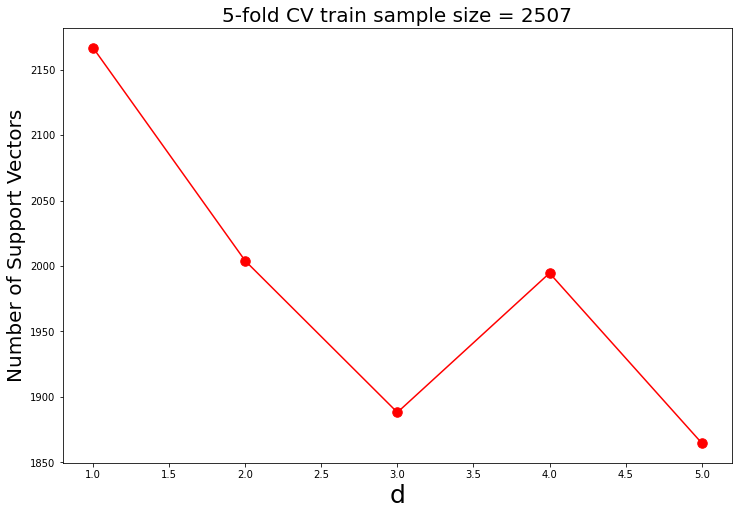

In [92]:
plt.figure(figsize=(12, 8))
plt.scatter(dlist, supp_vec_d, s=90, color='r')
plt.plot(dlist, supp_vec_d, color='r')
plt.xlabel("d", size=25)
plt.ylabel("Number of Support Vectors", size=20)
plt.title("5-fold CV train sample size = 2507", size=20)
plt.show()

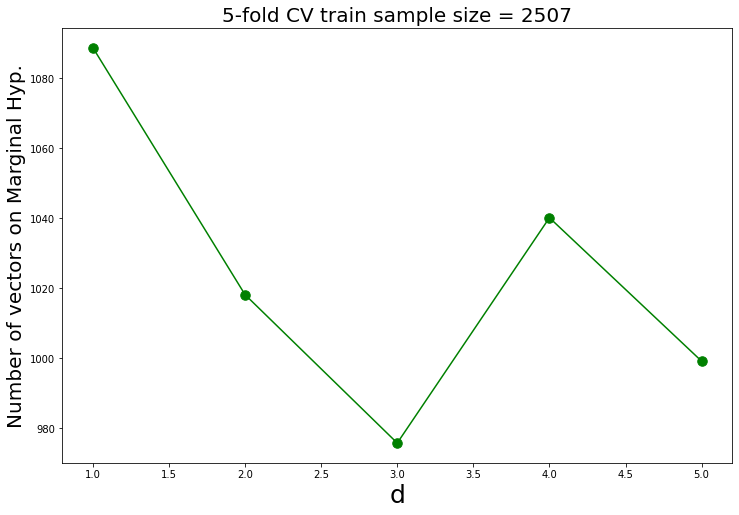

In [94]:
plt.figure(figsize=(12, 8))
plt.scatter(dlist, mh_vec_d, s=90, color='g')
plt.plot(dlist, mh_vec_d, color='g')
plt.xlabel("d", size=25)
plt.ylabel("Number of vectors on Marginal Hyp.", size=20)
plt.title("5-fold CV train sample size = 2507", size=20)
plt.show()

## Part 5

In [111]:
svc_pol  = SVR(kernel='poly', degree=d_star, C=C_star)
svc_pol  = svc_pol.fit( Xtrain, Ytrain )

# training error
yhat_pol_train = np.sign(svc_pol.predict(Xtrain))
svc_pol_resid_train = yhat_pol_train - Ytrain.values
train_error = np.sum(np.abs(svc_pol_resid_train/2.))/float(len(yhat_pol_train))  

# test error
yhat_pol_test = np.sign(svc_pol.predict(Xtest))
svc_pol_resid_test = yhat_pol_test - Ytest.values
test_error = np.sum(np.abs(svc_pol_resid_test/2.))/float(len(yhat_pol_test))  

In [170]:
print("d_star = ", d_star)
print("C_star = ", C_star)

d_star =  1
C_star =  6.777777777777778


In [114]:
print("Train Error = ", train_error)
print("Test Error = ", test_error)

Train Error =  0.22981168209383976
Test Error =  0.25383141762452105


## Part 6.c

In [164]:
# kernel function of degree d
def K(x,y,d):
    c = 1.0
    return (np.dot(x,y) + c)**d


# returns vector x'_i = ( y_1 K(x_i, x_1), ..., y_1 K(x_i, x_1) ), as defined in my homework solutions
def xp(i, X, Y, d):
    m = X.shape[0]
    xpi = np.zeros(m)
    for j in range(0,m):
        xpi[j] = Y[j]*K(X[i,:], X[j,:], d)
    return xpi


# returns matrix whose i-th row is x'_i
def Xp_matrix(X, Y, d):
    m = X.shape[0]
    Xp = np.zeros((m,m))
    for i in range(0,m):
        for j in range(0,m):
            Xp[i,j] = Y[j]*K(X[i,:], X[j,:], d)
    return Xp


# returns the target function which we want to minimize over alpha, b
def F(alpha, b, X, Y, d):
    m = X.shape[0]
    sum = 0.0
    for i in range(0,m):
        xpi = xp(i, X, Y, d)
        term = 1.0 - Y[i]*( np.dot(alpha,xpi) + b )
        if term > 0:
            sum = sum + term
    return 0.5*np.sum(alpha) + C_star*sum

# returns the target function which we want to minimize over alpha, b
def T(alpha, b, X, Xp, Y, d):
    m = X.shape[0]
    sum = 0.0
    Xpa = np.dot(Xp,alpha)
    for i in range(0,m):
        term = 1.0 - Y[i]*( Xpa[i] + b )
        if term > 0:
            sum = sum + term
    return 0.5*np.sum(alpha) + C_star*sum